In [170]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

In [171]:
import plotly
import plotly.graph_objects as go
plotly.__version__

'4.1.1'

In [172]:
np.random.seed(123)

## NUMBER OF ASSETS
n_assets = 4
## NUMBER OF OBSERVATIONS
n_obs = 1000
return_vec = np.random.randn(n_assets, n_obs)

In [173]:
fig = go.Figure()

for t in return_vec:
    tracer = go.Scatter(y=t, mode='lines')
    fig.add_trace(tracer)
fig.show()

In [174]:
def rand_weights(n):  
    k = np.random.rand(n)  
    return k / sum(k)

print(rand_weights(n_assets))
print(rand_weights(n_assets))

[0.54066805 0.2360283  0.11660484 0.1066988 ]
[0.27638339 0.03006307 0.47850085 0.21505269]


In [175]:
def random_portfolio(returns):  
    '''  
    Returns the mean and standard deviation of returns for a random portfolio  
    '''
    p = np.asmatrix(np.mean(returns, axis=1))  
    w = np.asmatrix(rand_weights(returns.shape[0]))  
    C = np.asmatrix(np.cov(returns))  
    
    mu = w * p.T  # Portfolio return
    sigma = np.sqrt(w * C * w.T)  # Portfolio sigma
    
    # This recursion reduces outliers to keep plots pretty  
    if sigma > 2:  
        return random_portfolio(returns)  
    return mu[0, 0], sigma[0, 0]

In [176]:
p = random_portfolio(return_vec)
print(p)

(0.02412320942011314, 0.514340039978287)


In [177]:
n_portfolios = 300  
z = np.vstack([random_portfolio(return_vec) for _ in range(n_portfolios)])
means = z[:, 0]
stds = z[:, 1]

In [178]:
z.shape

(300, 2)

In [179]:
fig = go.Figure()

trace = go.Scatter(x=stds, y=means, mode='markers')
fig.add_trace(trace)
fig.show()

In [207]:
solvers.options['show_progress'] = False  # disable notifications about optimization progress
"""
Use internal CVXOPT type of matricies
"""
def opt_port(rets, ret_lim):
    n = rets.shape[0]
    means = np.mean(return_vec, axis=1)
    
    # f = 0.5 * w *'COV* w + q'*w
    P = opt.matrix(np.cov(rets))
    q = opt.matrix(np.zeros((n, 1)))
    
    # w >= 0
    G = opt.matrix(-np.eye(n))
    h = opt.matrix(np.zeros((n, 1)))
    
    # sum(w) = 1
    # ret*w = ret_lim
    A = opt.matrix(np.vstack((np.ones((1, n)), means)))
    b = opt.matrix(np.array([[1], [ret_lim]]))
    
    # Calculate efficient frontier weights using quadratic programming  
    x = solvers.qp(P, q, G, h, A, b)['x']  # return cxopt.matrix 

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    pret = blas.dot(opt.matrix(means), x)  # means.T * x
    prisk = np.sqrt(blas.dotu(x, P*x))  # x.T * P * x
    return x, pret, prisk

def min_vol(rets):
    n = rets.shape[0]
    means = np.mean(return_vec, axis=1)
    
    # f = 0.5 * w *'COV* w + q'*w
    P = opt.matrix(np.cov(rets))
    q = opt.matrix(np.zeros((n, 1)))
    
    # w >= 0
    G = opt.matrix(-np.eye(n))
    h = opt.matrix(np.zeros((n, 1)))
    
    # sum(w) = 1
    # ret*w = ret_lim
    A = opt.matrix(np.ones((1, n)))
    b = opt.matrix(np.ones((1, 1)))
    
    # Calculate efficient frontier weights using quadratic programming  
    x = solvers.qp(P, q, G, h, A, b)['x']  # return cxopt.matrix 

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  
    pret = blas.dot(opt.matrix(means), x)  # means.T * x
    prisk = np.sqrt(blas.dotu(x, P*x))  # x.T * P * x
    return x, pret, prisk


In [240]:
"""
Maximize Sharpe ratio
"""
def max_sharpe(efp, efp_rets, efp_std, rfrate):
    sratios = list(map(lambda r, s: (r-rfrate)/s, efp_rets, efp_std))
    k_opt = np.argmax(sratios)
    
    return efp[k_opt], efp_rets[k_opt], efp_std[k_opt]

In [246]:
preturns = []
prisks = []
eff_portfolios = []
for ret_lim in np.linspace(0, 0.05, 100):
    pw, pret, pstd = opt_port(return_vec, ret_lim)
    eff_portfolios += [pw]
    preturns += [pret]
    prisks += [pstd]
    
gmv, gmvret, gmvstd = min_vol(return_vec)

sr, srret, srstd = max_sharpe(eff_portfolios, preturns, prisks, 0.01)
print(sr)

[ 1.04e-07]
[ 1.54e-01]
[ 1.35e-01]
[ 7.12e-01]



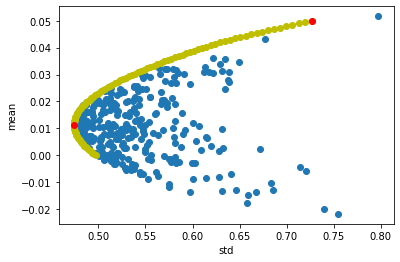

In [244]:
plt.plot(stds, means, 'o')  
plt.ylabel('mean')  
plt.xlabel('std')  

plt.plot(prisks, preturns, 'y-o')  

plt.plot(gmvstd, gmvret, 'r-o')

plt.plot(srstd, srret, 'r-o')